# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

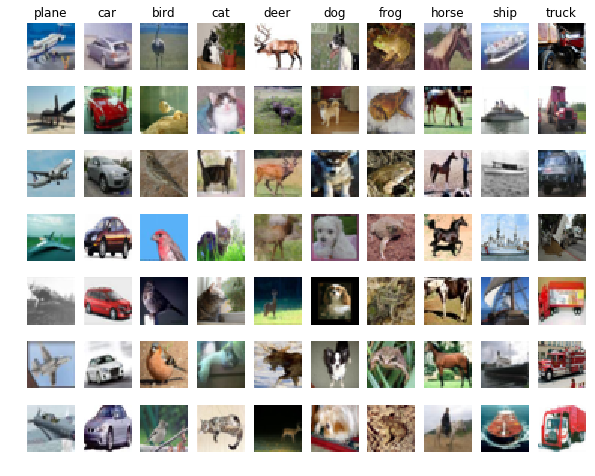

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64297917 135.92841667 132.4100625  130.0744375  135.3130625
 131.70479167 131.0373125  136.18741667 132.48804167 131.65420833]


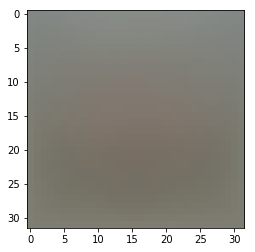

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropoy_loss_naive` function.

Running this method might take a while...

In [11]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))


loss: 2.313209
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
    <p> <b>Answer:</b> We know that the cross-entropy loss function is $$CF = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}y_{ic} \ln \biggl ({\frac{\exp(w^T_c x_i)}{\sum_{s=1}^{C}\exp(w^T_s x_i)}} \biggr ).$$
    $y_{ic}$ - one-hot-encoding, i.e. $y_{ic} = 1$ if $y[i] = c$, otherwise $0$. So in every row $ n = \overline{1,N}$ we have only one "1". Therefore, the sum over all classes and observations will give us $N$. </p>
    <p> Also we assume that the pictures in our database are distributed uniformly, it means that for any picture the estimated probability of it to be in a class "c" where $c \in \{0, \dots ,9\} $ is $$ \biggl ({\frac{\exp(w^T_c x_i)}{\sum_{s=1}^{C}\exp(w^T_s x_i)}} \biggr ) \approx \frac{1}{10} = 0.1 $$</p>
    
    <p> So finally we have $$CF \approx - \frac{1}{N} N * \ln(0.1) = -\ln(0.1).$$ </p>
</div>

Complete the implementation of the `cross_entropoy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [12]:
from exercise_code.gradient_check import grad_check_sparse
# We take a smaller dev set since the naive implementation takes quite some while
X_dev_small, y_dev_small = X_dev[:10], y_dev[:10]

loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 5.847877628628594 analytic: 5.847877605009475, relative error: 2.019460790103372e-09
numerical: -5.770087720824434 analytic: -5.770087763470063, relative error: 3.6954056121761755e-09
numerical: -2.383157428753613 analytic: -2.383157357077608, relative error: 1.5038034185261878e-08


In [13]:
# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: 2.409711181239338 analytic: 2.409711346640973, relative error: 3.4319803689781445e-08
numerical: -4.869350686642626 analytic: -4.869351070126363, relative error: 3.937729553562927e-08
numerical: 0.036720210982998935 analytic: 0.03672021586811615, relative error: 6.651809395702767e-08


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropoy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [14]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_vectorized

tic = time.time()
loss_naive, grad_naive = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)


naive loss: 2.313209e+00 computed in 0.207800s
vectorized loss: 2.313209e+00 computed in 0.036704s
Loss difference: 0.000000
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
      <p><b>Answer:</b> We can " normalize " our fuction with the exp in the power of the largest weight of the given class. In other words:
      $$ \sum_{s=1}^{C}\exp(w^T_s x_i), \quad \forall i \in \overline{1, n} \iff $$
      $$ \iff \sum_{s=1}^{C} \exp  \{{\max_{i \in 1 .. n }{w^T_s}}\} \exp\biggl (\frac{1}{\max_{i \in 1 .. n }{w^T_s}}(w^T_s x_i) \biggr ), $$
where $$w^T_s  = \pmatrix{w_1^s, \dots, w_n^s}$$     
</p>
<p> Such an approach must stabilize the computation. </p>
</p>
</div>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [23]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4, num_iters=1500, verbose=True)

#loss_hist_best = softmax.train(X_train, y_train, learning_rate=3e-7, reg=0.0, num_iters=10000, verbose=False)


toc = time.time()

print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1555.997280
iteration 100 / 1500: loss 209.481245
iteration 200 / 1500: loss 29.814652
iteration 300 / 1500: loss 5.879582
iteration 400 / 1500: loss 2.638993
iteration 500 / 1500: loss 2.209452
iteration 600 / 1500: loss 2.156972
iteration 700 / 1500: loss 2.141039
iteration 800 / 1500: loss 2.146949
iteration 900 / 1500: loss 2.148998
iteration 1000 / 1500: loss 2.160656
iteration 1100 / 1500: loss 2.120599
iteration 1200 / 1500: loss 2.143761
iteration 1300 / 1500: loss 2.119500
iteration 1400 / 1500: loss 2.096846
That took 22.163648s


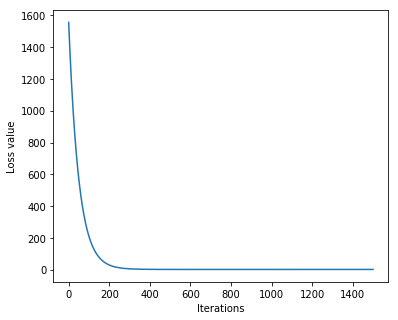

In [24]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
#plt.plot(loss_hist_best)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [25]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.315104
validation accuracy: 0.314000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set. Implement the `softmax_hyperparameter_tuning` function in `exercise_code/classifiers/softmax.py`.

In [37]:
from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

IN
9e-07 0.0 15000
iteration 0 / 15000: loss 5.609280
iteration 100 / 15000: loss 3.081872
iteration 200 / 15000: loss 2.678058
iteration 300 / 15000: loss 2.532242
iteration 400 / 15000: loss 2.296631
iteration 500 / 15000: loss 2.210681
iteration 600 / 15000: loss 2.247888
iteration 700 / 15000: loss 2.074951
iteration 800 / 15000: loss 2.023623
iteration 900 / 15000: loss 2.078656
iteration 1000 / 15000: loss 2.177168
iteration 1100 / 15000: loss 2.154287
iteration 1200 / 15000: loss 2.074591
iteration 1300 / 15000: loss 1.907382
iteration 1400 / 15000: loss 1.990692
iteration 1500 / 15000: loss 1.945806
iteration 1600 / 15000: loss 1.988971
iteration 1700 / 15000: loss 1.959767
iteration 1800 / 15000: loss 1.896012
iteration 1900 / 15000: loss 1.829507
iteration 2000 / 15000: loss 1.813459
iteration 2100 / 15000: loss 2.101342
iteration 2200 / 15000: loss 2.110720
iteration 2300 / 15000: loss 1.766178
iteration 2400 / 15000: loss 1.830744
iteration 2500 / 15000: loss 1.975829
itera

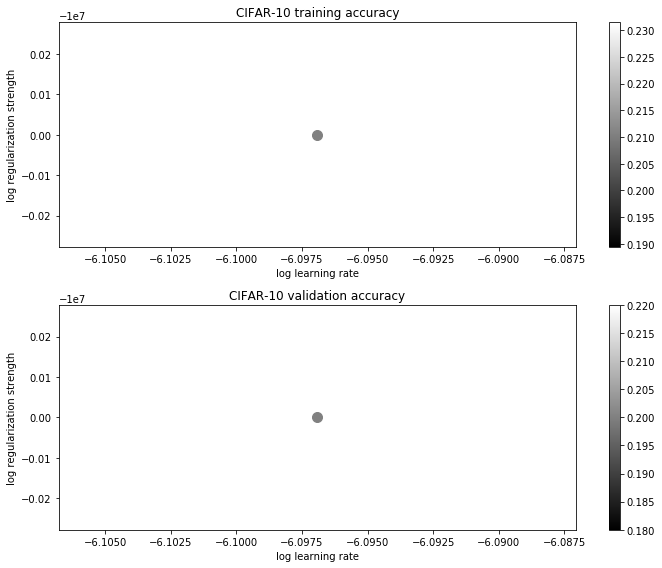

In [31]:
import math
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
#y_scatter = [math.log10(x[1]) for x in results]
y_scatter = np.empty(len(results), dtype = int)
i=0
for x in results:
    if(x[1]!=0.0):
        y_scatter[i]  = math.log10(x[1])
    else:
        y_scatter[i] = -10000000
    i=i+1

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [32]:
# if you want to take a look at the other classifiers assign them to best_softmax here
#sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])

#best_softmax_new = sorted_classifiers[-1][0]

best_softmax_new = all_classifiers[0]

In [38]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax_new.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.400000


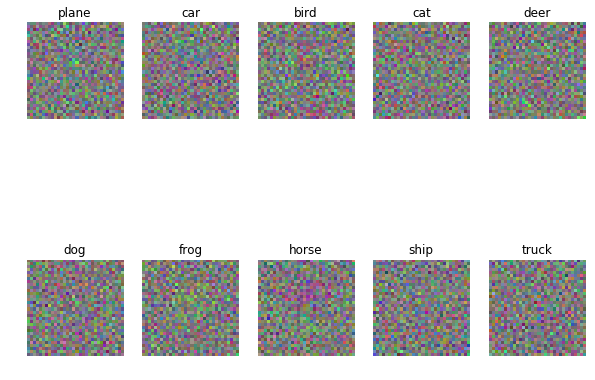

In [34]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

      # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
    <p> It is very hard to actually see the "average" of all images from a given class, due to the fact that the softmax does not capture the object on the image perfectly (the accuracy rate is only 0.4). Nevertheless, we can see that there is some vague shape of a frog and a horse. </p>
</div>

## Save the model

When you are satisfied with your training, save the model for submission. Your final score is computed by `accuracy * 100`. In order to pass this exercise, you have to achieve a score higher than __35__.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [39]:
from exercise_code.model_savers import save_softmax_classifier
from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)